## Якиманский А В - GARCH

Задание: Выберите ряд из первого задания и постройте его модель GARCH. Отчет нужно будет оформить в jupyter-ноутбук.

In [1]:
import pandas as pd
import numpy as np
import tqdm

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from scipy.stats import boxcox
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

Берем "изменения среднемесячной температуры"

In [2]:
series = pd.read_csv("mean-monthly-air-temperature-deg.csv")['Deg']

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()

Для проверки ряда на стационарность сделаем тест Дики-Фуллера и посмотрим на коррелограммы

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


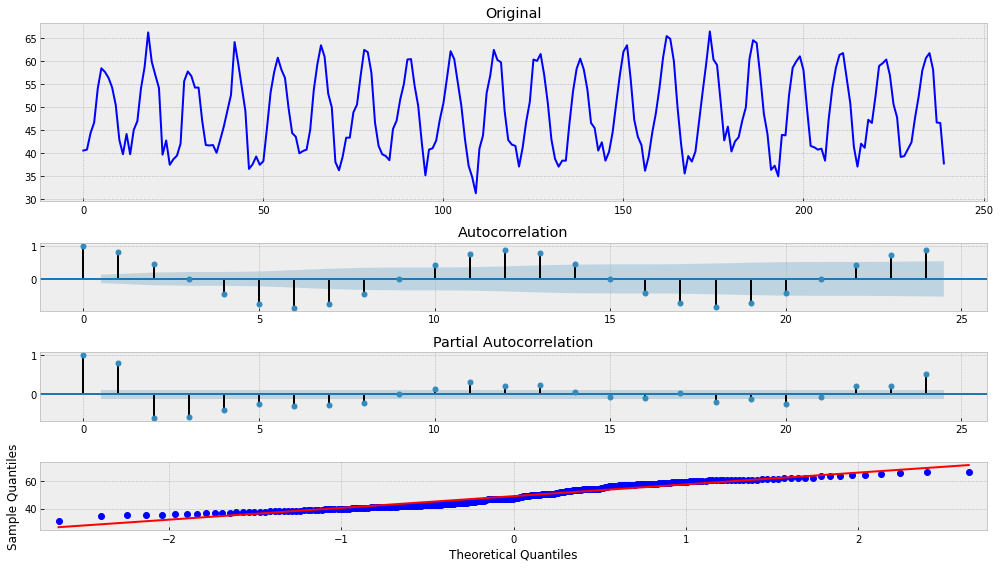

In [5]:
tsplot(series)

п-value меньше 0.05, но присутствует сезонность. Ряд не является стационарным. Перед построением модели GARCH необходимо построить модель ARIMA для получения оптимальных параметров p, o, q. 

aic: 1146.70169 | order: (2, 1, 4)

Results of Dickey-Fuller Test:
Test Statistic                  -5.376083
p-value                          0.000004
#Lags Used                       9.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64


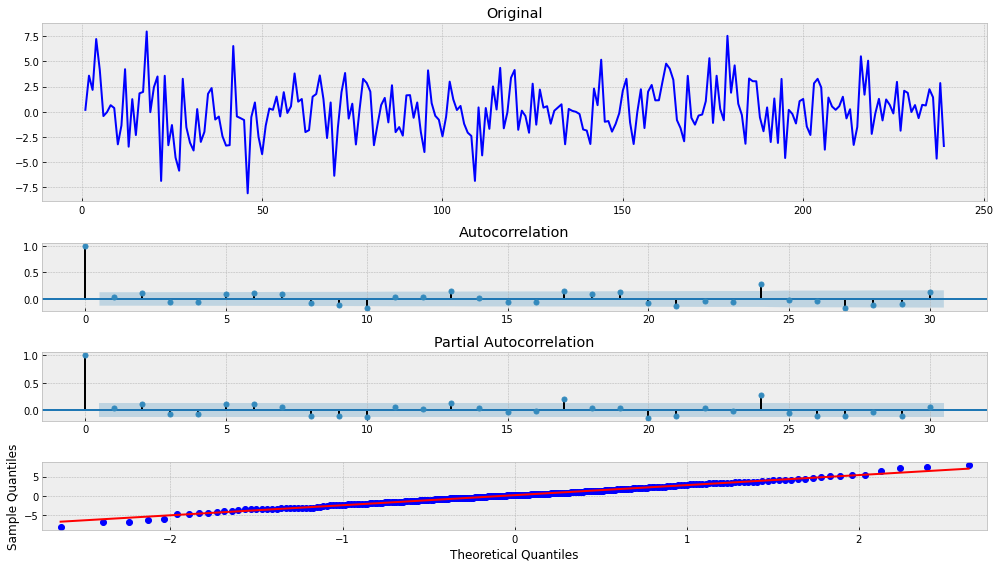

In [7]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

print()
tsplot(best_mdl.resid, lags=30)

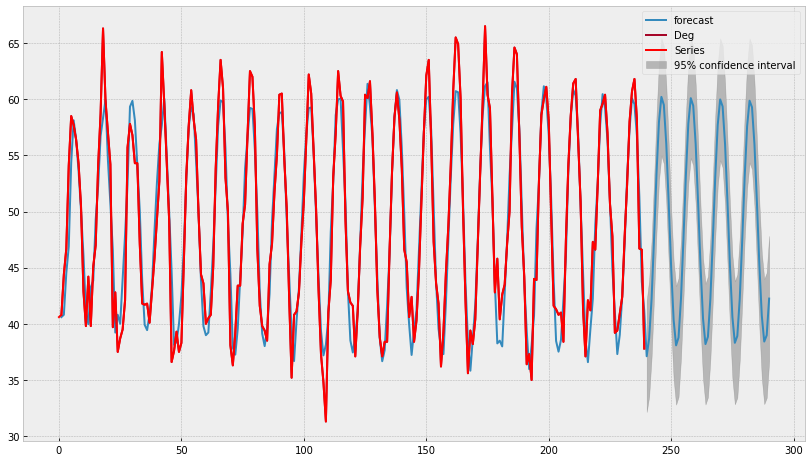

In [8]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(1, len(series)+50, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

Модель ARIMA подобрала оптимальные параметры 'p', 'o' и 'q':  (2, 1, 4). Построим теперь модель GARCH на этих параметрах.

In [11]:
from arch import arch_model
p_ = 2
o_ = 1
q_ = 4
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                          Deg   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -839.600
Distribution:      Standardized Student's t   AIC:                           1699.20
Method:                  Maximum Likelihood   BIC:                           1734.01
                                              No. Observations:                  240
Date:                      Sun, Sep 11 2022   Df Residuals:                      239
Time:                              09:41:13   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            45

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


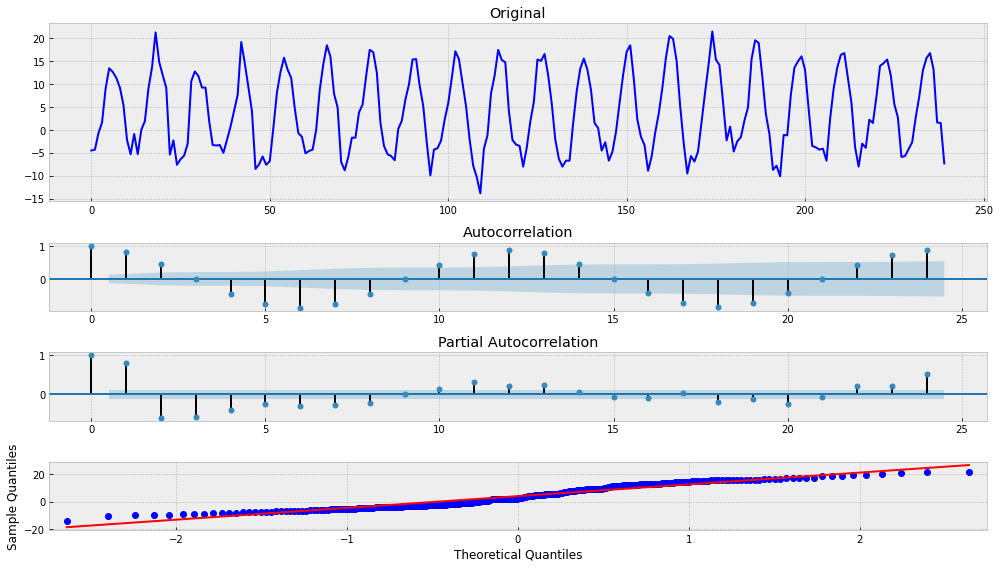

In [12]:
tsplot(res.resid)